In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import os
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout,LSTM

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime
from datetime import date, timedelta
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

data_path = 'D:/universidad/universidad 4/TFG/recursos para el desarrollo/datos procesados/OD'

In [2]:
delta = e_date - i_date

target_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    target_days.append(day)

In [3]:
def read_OD_fn(source_type):
    ods = {}
    for date in tqdm_notebook(target_days):
        od_date= pd.read_csv(os.path.join(data_path, 'date_{}_OD_{}.csv'.format(source_type,date.strftime('%Y-%m-%d'))), 
                            index_col=0)
        ods[date] = od_date
    return ods

In [4]:
ine_ods = read_OD_fn('INE')

  0%|          | 0/81 [00:00<?, ?it/s]

# Serializar los datos

In [5]:
lista = []

for date in tqdm_notebook(target_days):
    lista.append(ine_ods[date].loc['total','total'])
    
del ine_ods

  0%|          | 0/81 [00:00<?, ?it/s]

In [6]:
df = pd.DataFrame (lista, columns = ['Viajes'], index= target_days)

In [7]:
df.head()

,Viajes
2020-04-01,2213123
2020-04-02,2254121
2020-04-03,2520095
2020-04-04,1934554
2020-04-05,1593385


# Visualización de datos

In [8]:
print(df.index.min())
print(df.index.max())

2020-04-01 00:00:00
2020-06-20 00:00:00


In [9]:
print(len(df['2020']))

81


In [10]:
df.describe()

,Viajes
count,8.100000e+01
mean,3.438222e+06
std,1.174931e+06
min,1.535886e+06
25%,2.488436e+06
50%,3.396402e+06
75%,4.445190e+06
max,5.519725e+06


In [11]:
meses = df.resample('M').mean()
meses

,Viajes
2020-04-30,2.356878e+06
2020-05-31,3.590722e+06
2020-06-30,4.823862e+06


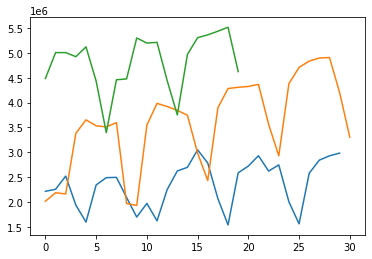

In [12]:
abril = df['2020-04-01':'2020-04-30']
plt.plot(abril.values)
mayo = df['2020-05-01':'2020-05-31']
plt.plot(mayo.values)
junio = df['2020-06-01':'2020-06-20']
plt.plot(junio.values)

# Preprocesado de datos

In [13]:
dataset = df.values
dataset = dataset.astype('float32')

In [14]:
# normalizamos el conjunto de datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Dividimos los datos en sets de entrenamiento y validacion

In [15]:
#dividimos nuestros valores entre sets de entrenamiento y de test
n_train_days = 60
train = dataset[:n_train_days, :]
test = dataset[n_train_days:, :]

print(len(train), len(test))

60 21


In [16]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [17]:
# dividimos en entradas y salidas
look_back = 7

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(len(trainX), len(testY))

53 14


In [18]:
print(trainX)

[[0.16999608 0.18028718 0.2470504  0.10007131 0.01443306 0.20226192
  0.23910356]
 [0.18028718 0.2470504  0.10007131 0.01443306 0.20226192 0.23910356
  0.24053836]
 [0.2470504  0.10007131 0.01443306 0.20226192 0.23910356 0.24053836
  0.1389401 ]
 [0.10007131 0.01443306 0.20226192 0.23910356 0.24053836 0.1389401
  0.03971621]
 [0.01443306 0.20226192 0.23910356 0.24053836 0.1389401  0.03971621
  0.10891479]
 [0.20226192 0.23910356 0.24053836 0.1389401  0.03971621 0.10891479
  0.02047423]
 [0.23910356 0.24053836 0.1389401  0.03971621 0.10891479 0.02047423
  0.17865783]
 [0.24053836 0.1389401  0.03971621 0.10891479 0.02047423 0.17865783
  0.27293295]
 [0.1389401  0.03971621 0.10891479 0.02047423 0.17865783 0.27293295
  0.2914425 ]
 [0.03971621 0.10891479 0.02047423 0.17865783 0.27293295 0.2914425
  0.37988257]
 [0.10891479 0.02047423 0.17865783 0.27293295 0.2914425  0.37988257
  0.313093  ]
 [0.02047423 0.17865783 0.27293295 0.2914425  0.37988257 0.313093
  0.13297123]
 [0.17865783 0.27293

In [19]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [20]:
print(trainX)

[[[0.16999608]
  [0.18028718]
  [0.2470504 ]
  [0.10007131]
  [0.01443306]
  [0.20226192]
  [0.23910356]]

 [[0.18028718]
  [0.2470504 ]
  [0.10007131]
  [0.01443306]
  [0.20226192]
  [0.23910356]
  [0.24053836]]

 [[0.2470504 ]
  [0.10007131]
  [0.01443306]
  [0.20226192]
  [0.23910356]
  [0.24053836]
  [0.1389401 ]]

 [[0.10007131]
  [0.01443306]
  [0.20226192]
  [0.23910356]
  [0.24053836]
  [0.1389401 ]
  [0.03971621]]

 [[0.01443306]
  [0.20226192]
  [0.23910356]
  [0.24053836]
  [0.1389401 ]
  [0.03971621]
  [0.10891479]]

 [[0.20226192]
  [0.23910356]
  [0.24053836]
  [0.1389401 ]
  [0.03971621]
  [0.10891479]
  [0.02047423]]

 [[0.23910356]
  [0.24053836]
  [0.1389401 ]
  [0.03971621]
  [0.10891479]
  [0.02047423]
  [0.17865783]]

 [[0.24053836]
  [0.1389401 ]
  [0.03971621]
  [0.10891479]
  [0.02047423]
  [0.17865783]
  [0.27293295]]

 [[0.1389401 ]
  [0.03971621]
  [0.10891479]
  [0.02047423]
  [0.17865783]
  [0.27293295]
  [0.2914425 ]]

 [[0.03971621]
  [0.10891479]
  [0.02

In [21]:
print(trainY)

[0.24053836 0.1389401  0.03971621 0.10891479 0.02047423 0.17865783
 0.27293295 0.2914425  0.37988257 0.313093   0.13297123 0.
 0.26343662 0.29775453 0.34997272 0.27233207 0.30363703 0.11689752
 0.00537395 0.26156402 0.32788748 0.3494845  0.36331165 0.11988008
 0.16276813 0.1565342  0.46347785 0.5314964  0.50147784 0.49586993
 0.51747626 0.10823756 0.09844148 0.5044481  0.61485875 0.59899086
 0.5796803  0.5546241  0.3633111  0.22455525 0.59261984 0.689921
 0.6962447  0.7003162  0.71110225 0.50901634 0.34968656 0.7144731
 0.7966052  0.82881963 0.8441757  0.8469062  0.6693162 ]


# Creamos la red neuronal

In [22]:
def crear_modeloFF():
    model = Sequential() 
    model.add(LSTM(20, input_shape=(look_back,1), return_sequences=True))
    model.add(LSTM(50, input_shape=(look_back,1), return_sequences=True))
    model.add(Dropout(0.30))
    model.add(LSTM(100, input_shape=(look_back,1)))
    model.add(Dropout(0.30))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return model

In [23]:
model = crear_modeloFF()

history=model.fit(trainX, trainY, epochs=200, validation_data=(testX,testY), batch_size=1, verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 20)             1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 50)             14200     
_________________________________________________________________
dropout (Dropout)            (None, 7, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 76,461
Trainable params: 76,461
Non-trainable params: 0
____________________________________________________

Epoch 123/200
53/53 - 0s - loss: 0.0156 - val_loss: 0.0160
Epoch 124/200
53/53 - 0s - loss: 0.0176 - val_loss: 0.0193
Epoch 125/200
53/53 - 0s - loss: 0.0148 - val_loss: 0.0132
Epoch 126/200
53/53 - 0s - loss: 0.0178 - val_loss: 0.0451
Epoch 127/200
53/53 - 0s - loss: 0.0168 - val_loss: 0.0171
Epoch 128/200
53/53 - 0s - loss: 0.0133 - val_loss: 0.0134
Epoch 129/200
53/53 - 0s - loss: 0.0181 - val_loss: 0.0175
Epoch 130/200
53/53 - 0s - loss: 0.0153 - val_loss: 0.0161
Epoch 131/200
53/53 - 0s - loss: 0.0145 - val_loss: 0.0137
Epoch 132/200
53/53 - 0s - loss: 0.0133 - val_loss: 0.0128
Epoch 133/200
53/53 - 0s - loss: 0.0153 - val_loss: 0.0120
Epoch 134/200
53/53 - 0s - loss: 0.0162 - val_loss: 0.0297
Epoch 135/200
53/53 - 0s - loss: 0.0191 - val_loss: 0.0301
Epoch 136/200
53/53 - 0s - loss: 0.0206 - val_loss: 0.0170
Epoch 137/200
53/53 - 0s - loss: 0.0144 - val_loss: 0.0237
Epoch 138/200
53/53 - 0s - loss: 0.0141 - val_loss: 0.0161
Epoch 139/200
53/53 - 0s - loss: 0.0154 - val_loss: 0.01

# Visualizamos resultados

In [24]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


def compute_metrics_fn(y_valid_resc, y_hat_resc):
    mae_ = mean_absolute_error(y_valid_resc, y_hat_resc)
    mse_ = mean_squared_error(y_valid_resc, y_hat_resc)
    rmse_ = mean_squared_error(y_valid_resc, y_hat_resc, squared = False)
    cvrmse_ = rmse_/np.mean(y_valid_resc)*100
    mape_ = mape(y_valid_resc, y_hat_resc)
    
    return mae_, mse_, rmse_, cvrmse_, mape_

In [25]:
# hacemos las predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invertimos las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY_scalerInverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_scalerInverse = scaler.inverse_transform([testY])

In [26]:
# calculamos las metricas de error
trainScore_MAE, trainScore_MSE, trainScore_RMSE, trainScore_CVRMSE, trainScore_MAPE  =  compute_metrics_fn(trainY_scalerInverse[0], trainPredict[:,0])
print('Resultado del entrenamiento: %.2f MAE' % (trainScore_MAE))
print('Resultado del entrenamiento: %.2f MSE' % (trainScore_MSE))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore_RMSE))
print('Resultado del entrenamiento: %.2f CVRMSE' % (trainScore_CVRMSE))
print('Resultado del entrenamiento: %.2f MAPE \n' % (trainScore_MAPE))

testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(testY_scalerInverse[0], testPredict[:,0])
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del entrenamiento: 275585.69 MAE
Resultado del entrenamiento: 116953196726.34 MSE
Resultado del entrenamiento: 341984.21 RMSE
Resultado del entrenamiento: 11.09 CVRMSE
Resultado del entrenamiento: 9.82 MAPE 

Resultado del test: 510910.17 MAE
Resultado del test: 357466038225.28 MSE
Resultado del test: 597884.64 RMSE
Resultado del test: 12.40 CVRMSE
Resultado del test: 10.29 MAPE


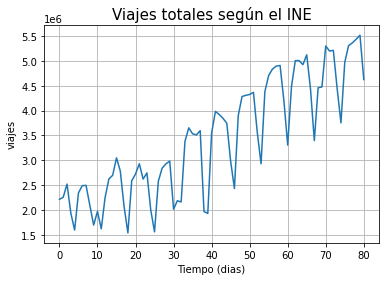

In [27]:
plt.plot(df.values)
plt.grid(True)
plt.title("Viajes totales según el INE", fontsize = 15)
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes", fontsize = 10)
plt.show()

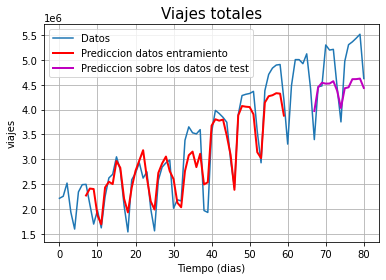

In [28]:
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# predicciones del test de cambio para plotear
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset), :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.title("Viajes totales", fontsize = 15)
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes", fontsize = 10)
plt.show()

In [29]:
results=testPredict
print(len(results))

14


In [30]:
testResults = testY_scalerInverse[0]

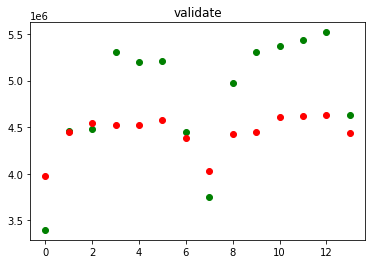

In [31]:
plt.scatter(range(len(testResults)),testResults,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

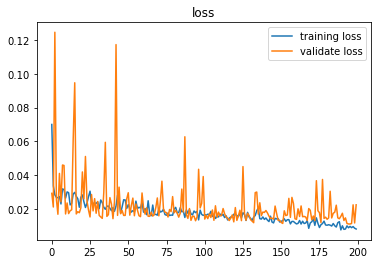

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.legend( ('training loss', 'validate loss'), loc = 'upper right')
plt.show()

In [33]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

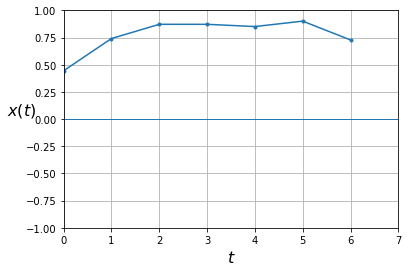

In [34]:
n_steps = 6 #preguntar
plot_series(testX[0, :, 0], testY_scalerInverse[0, 0], testPredict[0, 0])
plt.show()

# Exportar los datos

In [35]:
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-06-07', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(testPredict, index= index_days)
prediccion.columns = ['valor predicho']

prediccion

,valor predicho
2020-06-07,3972709.50
2020-06-08,4448479.00
2020-06-09,4541556.00
2020-06-10,4524280.50
2020-06-11,4526183.50
2020-06-12,4573506.50
2020-06-13,4381353.50
2020-06-14,4033736.25
2020-06-15,4431279.00
2020-06-16,4450090.00


In [36]:
datosReales = df['2020-6-07':'2020-6-20']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']

compara

,real,prediccion
2020-06-07,3396402,3972709.50
2020-06-08,4461143,4448479.00
2020-06-09,4478072,4541556.00
2020-06-10,5303428,4524280.50
2020-06-11,5200931,4526183.50
2020-06-12,5215302,4573506.50
2020-06-13,4445190,4381353.50
2020-06-14,3753016,4033736.25
2020-06-15,4973188,4431279.00
2020-06-16,5308885,4450090.00


In [37]:
compara.to_excel('Resultados INE.xlsx', columns=['real', 'prediccion'])

# Prediccion a futuro

In [38]:
# usaremos 7 dias que poseemos para predecir los 7 dias siguientes tras esto compararemos los resultados con los que
# poseemos para ver el grado de error

Dias = df['2020-5-18':'2020-5-24']

In [39]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos, en este caso modificada para ayudarnos a crear
#los distintos sets de entrenmiento para distintos modelos que predeciran 1 dia cada uno

def create_dataset2(dataset, look_back=1, dias=0):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-dias):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back + dias, 0])
  return np.array(dataX), np.array(dataY)

In [40]:
#ahora crearemos los sets para entrenar los modelos
look_back = 7

trainX1, trainY1 = create_dataset2(train, look_back, 1)
testX1, testY1 = create_dataset2(test, look_back, 1)

trainX2, trainY2 = create_dataset2(train, look_back, 2)
testX2, testY2 = create_dataset2(test, look_back, 2)

trainX3, trainY3 = create_dataset2(train, look_back, 3)
testX3, testY3 = create_dataset2(test, look_back, 3)

trainX4, trainY4 = create_dataset2(train, look_back, 4)
testX4, testY4 = create_dataset2(test, look_back, 4)

trainX5, trainY5 = create_dataset2(train, look_back, 5)
testX5, testY5 = create_dataset2(test, look_back, 5)

trainX6, trainY6 = create_dataset2(train, look_back, 6)
testX6, testY6 = create_dataset2(test, look_back, 6)

In [41]:
print(trainX1)

[[0.16999608 0.18028718 0.2470504  0.10007131 0.01443306 0.20226192
  0.23910356]
 [0.18028718 0.2470504  0.10007131 0.01443306 0.20226192 0.23910356
  0.24053836]
 [0.2470504  0.10007131 0.01443306 0.20226192 0.23910356 0.24053836
  0.1389401 ]
 [0.10007131 0.01443306 0.20226192 0.23910356 0.24053836 0.1389401
  0.03971621]
 [0.01443306 0.20226192 0.23910356 0.24053836 0.1389401  0.03971621
  0.10891479]
 [0.20226192 0.23910356 0.24053836 0.1389401  0.03971621 0.10891479
  0.02047423]
 [0.23910356 0.24053836 0.1389401  0.03971621 0.10891479 0.02047423
  0.17865783]
 [0.24053836 0.1389401  0.03971621 0.10891479 0.02047423 0.17865783
  0.27293295]
 [0.1389401  0.03971621 0.10891479 0.02047423 0.17865783 0.27293295
  0.2914425 ]
 [0.03971621 0.10891479 0.02047423 0.17865783 0.27293295 0.2914425
  0.37988257]
 [0.10891479 0.02047423 0.17865783 0.27293295 0.2914425  0.37988257
  0.313093  ]
 [0.02047423 0.17865783 0.27293295 0.2914425  0.37988257 0.313093
  0.13297123]
 [0.17865783 0.27293

In [42]:
print(trainY1)

[0.1389401  0.03971621 0.10891479 0.02047423 0.17865783 0.27293295
 0.2914425  0.37988257 0.313093   0.13297123 0.         0.26343662
 0.29775453 0.34997272 0.27233207 0.30363703 0.11689752 0.00537395
 0.26156402 0.32788748 0.3494845  0.36331165 0.11988008 0.16276813
 0.1565342  0.46347785 0.5314964  0.50147784 0.49586993 0.51747626
 0.10823756 0.09844148 0.5044481  0.61485875 0.59899086 0.5796803
 0.5546241  0.3633111  0.22455525 0.59261984 0.689921   0.6962447
 0.7003162  0.71110225 0.50901634 0.34968656 0.7144731  0.7966052
 0.82881963 0.8441757  0.8469062  0.6693162 ]


In [43]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]

trainX1 = np.reshape(trainX1, (trainX1.shape[0], trainX1.shape[1], 1))
testX1 = np.reshape(testX1, (testX1.shape[0], testX1.shape[1], 1))

trainX2 = np.reshape(trainX2, (trainX2.shape[0], trainX2.shape[1], 1))
testX2 = np.reshape(testX2, (testX2.shape[0], testX2.shape[1], 1))

trainX3 = np.reshape(trainX3, (trainX3.shape[0], trainX3.shape[1], 1))
testX3 = np.reshape(testX3, (testX3.shape[0], testX3.shape[1], 1))

trainX4 = np.reshape(trainX4, (trainX4.shape[0], trainX4.shape[1], 1))
testX4 = np.reshape(testX4, (testX4.shape[0], testX4.shape[1], 1))

trainX5 = np.reshape(trainX5, (trainX5.shape[0], trainX5.shape[1], 1))
testX5 = np.reshape(testX5, (testX5.shape[0], testX5.shape[1], 1))

trainX6 = np.reshape(trainX6, (trainX6.shape[0], trainX6.shape[1], 1))
testX6 = np.reshape(testX6, (testX6.shape[0], testX6.shape[1], 1))

In [44]:
#creamos los distintos modelos para predecir cada dia

model1 = crear_modeloFF()
history=model1.fit(trainX1, trainY1, epochs=200, validation_data=(testX1,testY1), batch_size=1, verbose=2)

model2 = crear_modeloFF()
history=model2.fit(trainX2, trainY2, epochs=200, validation_data=(testX2,testY2), batch_size=1, verbose=2)

model3 = crear_modeloFF()
history=model3.fit(trainX3, trainY3, epochs=200, validation_data=(testX3,testY3), batch_size=1, verbose=2)

model4 = crear_modeloFF()
history=model4.fit(trainX4, trainY4, epochs=200, validation_data=(testX4,testY4), batch_size=1, verbose=2)

model5 = crear_modeloFF()
history=model5.fit(trainX5, trainY5, epochs=200, validation_data=(testX5,testY5), batch_size=1, verbose=2)

model6 = crear_modeloFF()
history=model6.fit(trainX6, trainY6, epochs=200, validation_data=(testX6,testY6), batch_size=1, verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 7, 20)             1760      
_________________________________________________________________
lstm_4 (LSTM)                (None, 7, 50)             14200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 76,461
Trainable params: 76,461
Non-trainable params: 0
__________________________________________________

52/52 - 0s - loss: 0.0118 - val_loss: 0.0127
Epoch 123/200
52/52 - 0s - loss: 0.0128 - val_loss: 0.0130
Epoch 124/200
52/52 - 0s - loss: 0.0129 - val_loss: 0.0196
Epoch 125/200
52/52 - 0s - loss: 0.0120 - val_loss: 0.0089
Epoch 126/200
52/52 - 0s - loss: 0.0132 - val_loss: 0.0214
Epoch 127/200
52/52 - 0s - loss: 0.0135 - val_loss: 0.0107
Epoch 128/200
52/52 - 0s - loss: 0.0124 - val_loss: 0.0097
Epoch 129/200
52/52 - 0s - loss: 0.0133 - val_loss: 0.0112
Epoch 130/200
52/52 - 0s - loss: 0.0121 - val_loss: 0.0162
Epoch 131/200
52/52 - 0s - loss: 0.0136 - val_loss: 0.0164
Epoch 132/200
52/52 - 0s - loss: 0.0130 - val_loss: 0.0124
Epoch 133/200
52/52 - 0s - loss: 0.0135 - val_loss: 0.0156
Epoch 134/200
52/52 - 0s - loss: 0.0116 - val_loss: 0.0125
Epoch 135/200
52/52 - 0s - loss: 0.0119 - val_loss: 0.0146
Epoch 136/200
52/52 - 0s - loss: 0.0127 - val_loss: 0.0117
Epoch 137/200
52/52 - 0s - loss: 0.0122 - val_loss: 0.0160
Epoch 138/200
52/52 - 0s - loss: 0.0115 - val_loss: 0.0129
Epoch 139/2

Epoch 43/200
51/51 - 0s - loss: 0.0187 - val_loss: 0.0148
Epoch 44/200
51/51 - 0s - loss: 0.0130 - val_loss: 0.0103
Epoch 45/200
51/51 - 0s - loss: 0.0149 - val_loss: 0.0097
Epoch 46/200
51/51 - 0s - loss: 0.0169 - val_loss: 0.0381
Epoch 47/200
51/51 - 0s - loss: 0.0172 - val_loss: 0.0193
Epoch 48/200
51/51 - 0s - loss: 0.0127 - val_loss: 0.0523
Epoch 49/200
51/51 - 0s - loss: 0.0181 - val_loss: 0.0090
Epoch 50/200
51/51 - 0s - loss: 0.0159 - val_loss: 0.0227
Epoch 51/200
51/51 - 0s - loss: 0.0134 - val_loss: 0.0149
Epoch 52/200
51/51 - 0s - loss: 0.0141 - val_loss: 0.0193
Epoch 53/200
51/51 - 0s - loss: 0.0149 - val_loss: 0.0300
Epoch 54/200
51/51 - 0s - loss: 0.0151 - val_loss: 0.0131
Epoch 55/200
51/51 - 0s - loss: 0.0144 - val_loss: 0.0158
Epoch 56/200
51/51 - 0s - loss: 0.0154 - val_loss: 0.0083
Epoch 57/200
51/51 - 0s - loss: 0.0138 - val_loss: 0.0089
Epoch 58/200
51/51 - 0s - loss: 0.0143 - val_loss: 0.0087
Epoch 59/200
51/51 - 0s - loss: 0.0150 - val_loss: 0.0376
Epoch 60/200
5

Epoch 183/200
51/51 - 0s - loss: 0.0107 - val_loss: 0.0106
Epoch 184/200
51/51 - 0s - loss: 0.0119 - val_loss: 0.0114
Epoch 185/200
51/51 - 0s - loss: 0.0128 - val_loss: 0.0131
Epoch 186/200
51/51 - 0s - loss: 0.0130 - val_loss: 0.0131
Epoch 187/200
51/51 - 0s - loss: 0.0107 - val_loss: 0.0102
Epoch 188/200
51/51 - 0s - loss: 0.0102 - val_loss: 0.0194
Epoch 189/200
51/51 - 0s - loss: 0.0098 - val_loss: 0.0130
Epoch 190/200
51/51 - 0s - loss: 0.0098 - val_loss: 0.0189
Epoch 191/200
51/51 - 0s - loss: 0.0103 - val_loss: 0.0107
Epoch 192/200
51/51 - 0s - loss: 0.0112 - val_loss: 0.0103
Epoch 193/200
51/51 - 0s - loss: 0.0113 - val_loss: 0.0112
Epoch 194/200
51/51 - 0s - loss: 0.0113 - val_loss: 0.0140
Epoch 195/200
51/51 - 0s - loss: 0.0110 - val_loss: 0.0104
Epoch 196/200
51/51 - 0s - loss: 0.0108 - val_loss: 0.0162
Epoch 197/200
51/51 - 0s - loss: 0.0102 - val_loss: 0.0107
Epoch 198/200
51/51 - 0s - loss: 0.0106 - val_loss: 0.0096
Epoch 199/200
51/51 - 0s - loss: 0.0115 - val_loss: 0.00

50/50 - 0s - loss: 0.0100 - val_loss: 0.0127
Epoch 105/200
50/50 - 0s - loss: 0.0107 - val_loss: 0.0128
Epoch 106/200
50/50 - 0s - loss: 0.0107 - val_loss: 0.0145
Epoch 107/200
50/50 - 0s - loss: 0.0094 - val_loss: 0.0107
Epoch 108/200
50/50 - 0s - loss: 0.0114 - val_loss: 0.0109
Epoch 109/200
50/50 - 0s - loss: 0.0094 - val_loss: 0.0132
Epoch 110/200
50/50 - 0s - loss: 0.0118 - val_loss: 0.0118
Epoch 111/200
50/50 - 0s - loss: 0.0118 - val_loss: 0.0111
Epoch 112/200
50/50 - 0s - loss: 0.0130 - val_loss: 0.0215
Epoch 113/200
50/50 - 0s - loss: 0.0109 - val_loss: 0.0215
Epoch 114/200
50/50 - 0s - loss: 0.0116 - val_loss: 0.0286
Epoch 115/200
50/50 - 0s - loss: 0.0118 - val_loss: 0.0331
Epoch 116/200
50/50 - 0s - loss: 0.0093 - val_loss: 0.0141
Epoch 117/200
50/50 - 0s - loss: 0.0118 - val_loss: 0.0120
Epoch 118/200
50/50 - 0s - loss: 0.0131 - val_loss: 0.0135
Epoch 119/200
50/50 - 0s - loss: 0.0109 - val_loss: 0.0128
Epoch 120/200
50/50 - 0s - loss: 0.0099 - val_loss: 0.0176
Epoch 121/2

49/49 - 0s - loss: 0.0207 - val_loss: 0.0458
Epoch 25/200
49/49 - 0s - loss: 0.0187 - val_loss: 0.0310
Epoch 26/200
49/49 - 0s - loss: 0.0209 - val_loss: 0.0166
Epoch 27/200
49/49 - 0s - loss: 0.0182 - val_loss: 0.0075
Epoch 28/200
49/49 - 0s - loss: 0.0175 - val_loss: 0.0264
Epoch 29/200
49/49 - 0s - loss: 0.0167 - val_loss: 0.0556
Epoch 30/200
49/49 - 0s - loss: 0.0161 - val_loss: 0.0139
Epoch 31/200
49/49 - 0s - loss: 0.0185 - val_loss: 0.0421
Epoch 32/200
49/49 - 0s - loss: 0.0131 - val_loss: 0.0429
Epoch 33/200
49/49 - 0s - loss: 0.0168 - val_loss: 0.0370
Epoch 34/200
49/49 - 0s - loss: 0.0204 - val_loss: 0.0074
Epoch 35/200
49/49 - 0s - loss: 0.0161 - val_loss: 0.0074
Epoch 36/200
49/49 - 0s - loss: 0.0175 - val_loss: 0.0076
Epoch 37/200
49/49 - 0s - loss: 0.0191 - val_loss: 0.0074
Epoch 38/200
49/49 - 0s - loss: 0.0188 - val_loss: 0.0191
Epoch 39/200
49/49 - 0s - loss: 0.0201 - val_loss: 0.0116
Epoch 40/200
49/49 - 0s - loss: 0.0191 - val_loss: 0.0199
Epoch 41/200
49/49 - 0s - l

Epoch 165/200
49/49 - 0s - loss: 0.0095 - val_loss: 0.0094
Epoch 166/200
49/49 - 0s - loss: 0.0096 - val_loss: 0.0095
Epoch 167/200
49/49 - 0s - loss: 0.0107 - val_loss: 0.0064
Epoch 168/200
49/49 - 0s - loss: 0.0089 - val_loss: 0.0254
Epoch 169/200
49/49 - 0s - loss: 0.0112 - val_loss: 0.0263
Epoch 170/200
49/49 - 0s - loss: 0.0105 - val_loss: 0.0123
Epoch 171/200
49/49 - 0s - loss: 0.0089 - val_loss: 0.0132
Epoch 172/200
49/49 - 0s - loss: 0.0102 - val_loss: 0.0230
Epoch 173/200
49/49 - 0s - loss: 0.0112 - val_loss: 0.0258
Epoch 174/200
49/49 - 0s - loss: 0.0093 - val_loss: 0.0110
Epoch 175/200
49/49 - 0s - loss: 0.0130 - val_loss: 0.0068
Epoch 176/200
49/49 - 0s - loss: 0.0107 - val_loss: 0.0034
Epoch 177/200
49/49 - 0s - loss: 0.0112 - val_loss: 0.0071
Epoch 178/200
49/49 - 0s - loss: 0.0120 - val_loss: 0.0011
Epoch 179/200
49/49 - 0s - loss: 0.0093 - val_loss: 0.0115
Epoch 180/200
49/49 - 0s - loss: 0.0104 - val_loss: 0.0034
Epoch 181/200
49/49 - 0s - loss: 0.0122 - val_loss: 0.01

Epoch 86/200
48/48 - 0s - loss: 0.0130 - val_loss: 0.0097
Epoch 87/200
48/48 - 0s - loss: 0.0120 - val_loss: 0.0123
Epoch 88/200
48/48 - 0s - loss: 0.0115 - val_loss: 0.0098
Epoch 89/200
48/48 - 0s - loss: 0.0135 - val_loss: 0.0202
Epoch 90/200
48/48 - 0s - loss: 0.0129 - val_loss: 0.0072
Epoch 91/200
48/48 - 0s - loss: 0.0107 - val_loss: 0.0074
Epoch 92/200
48/48 - 0s - loss: 0.0136 - val_loss: 0.0248
Epoch 93/200
48/48 - 0s - loss: 0.0125 - val_loss: 0.0225
Epoch 94/200
48/48 - 0s - loss: 0.0109 - val_loss: 0.0075
Epoch 95/200
48/48 - 0s - loss: 0.0122 - val_loss: 0.0096
Epoch 96/200
48/48 - 0s - loss: 0.0120 - val_loss: 0.0279
Epoch 97/200
48/48 - 0s - loss: 0.0099 - val_loss: 0.0180
Epoch 98/200
48/48 - 0s - loss: 0.0113 - val_loss: 0.0143
Epoch 99/200
48/48 - 0s - loss: 0.0119 - val_loss: 0.0090
Epoch 100/200
48/48 - 0s - loss: 0.0127 - val_loss: 0.0101
Epoch 101/200
48/48 - 0s - loss: 0.0118 - val_loss: 0.0107
Epoch 102/200
48/48 - 0s - loss: 0.0154 - val_loss: 0.0290
Epoch 103/2

Epoch 6/200
47/47 - 0s - loss: 0.0363 - val_loss: 0.0733
Epoch 7/200
47/47 - 0s - loss: 0.0355 - val_loss: 0.0998
Epoch 8/200
47/47 - 0s - loss: 0.0409 - val_loss: 0.0329
Epoch 9/200
47/47 - 0s - loss: 0.0377 - val_loss: 0.0279
Epoch 10/200
47/47 - 0s - loss: 0.0372 - val_loss: 0.0345
Epoch 11/200
47/47 - 0s - loss: 0.0346 - val_loss: 0.0533
Epoch 12/200
47/47 - 0s - loss: 0.0475 - val_loss: 0.0667
Epoch 13/200
47/47 - 0s - loss: 0.0413 - val_loss: 0.0304
Epoch 14/200
47/47 - 0s - loss: 0.0380 - val_loss: 0.0288
Epoch 15/200
47/47 - 0s - loss: 0.0327 - val_loss: 0.0315
Epoch 16/200
47/47 - 0s - loss: 0.0346 - val_loss: 0.0260
Epoch 17/200
47/47 - 0s - loss: 0.0360 - val_loss: 0.0347
Epoch 18/200
47/47 - 0s - loss: 0.0301 - val_loss: 0.0380
Epoch 19/200
47/47 - 0s - loss: 0.0364 - val_loss: 0.0327
Epoch 20/200
47/47 - 0s - loss: 0.0307 - val_loss: 0.0608
Epoch 21/200
47/47 - 0s - loss: 0.0329 - val_loss: 0.0286
Epoch 22/200
47/47 - 0s - loss: 0.0383 - val_loss: 0.1634
Epoch 23/200
47/47

Epoch 147/200
47/47 - 0s - loss: 0.0097 - val_loss: 0.0277
Epoch 148/200
47/47 - 0s - loss: 0.0082 - val_loss: 0.0227
Epoch 149/200
47/47 - 0s - loss: 0.0106 - val_loss: 0.0045
Epoch 150/200
47/47 - 0s - loss: 0.0107 - val_loss: 0.0044
Epoch 151/200
47/47 - 0s - loss: 0.0084 - val_loss: 0.0204
Epoch 152/200
47/47 - 0s - loss: 0.0089 - val_loss: 0.0189
Epoch 153/200
47/47 - 0s - loss: 0.0090 - val_loss: 0.0072
Epoch 154/200
47/47 - 0s - loss: 0.0097 - val_loss: 0.0065
Epoch 155/200
47/47 - 0s - loss: 0.0084 - val_loss: 0.0085
Epoch 156/200
47/47 - 0s - loss: 0.0097 - val_loss: 0.0247
Epoch 157/200
47/47 - 0s - loss: 0.0090 - val_loss: 0.0064
Epoch 158/200
47/47 - 0s - loss: 0.0086 - val_loss: 0.0055
Epoch 159/200
47/47 - 0s - loss: 0.0097 - val_loss: 0.0134
Epoch 160/200
47/47 - 0s - loss: 0.0082 - val_loss: 0.0077
Epoch 161/200
47/47 - 0s - loss: 0.0104 - val_loss: 0.0041
Epoch 162/200
47/47 - 0s - loss: 0.0104 - val_loss: 0.0176
Epoch 163/200
47/47 - 0s - loss: 0.0089 - val_loss: 0.00

# Preparamos los datos para el test

In [45]:
# cargamos el dataframe en la variable dataset
dataset = Dias.values

# convertimos los enteros en floats
dataset = dataset.astype('float32')

# normalizamos los datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [46]:
#remodelamos los datos
testX = np.reshape(dataset, (1, 7, 1))

# Predicciones para la proxima semana

In [47]:
results = []

parcial=model.predict(testX)
results.append(parcial[0])

parcial=model1.predict(testX)
results.append(parcial[0])

parcial=model2.predict(testX)
results.append(parcial[0])

parcial=model3.predict(testX)
results.append(parcial[0])

parcial=model4.predict(testX)
results.append(parcial[0])

parcial=model5.predict(testX)
results.append(parcial[0])

parcial=model6.predict(testX)
results.append(parcial[0])

results = np.reshape(results, (7, 1))
print(results)

[[0.7055479 ]
 [0.7633771 ]
 [0.97149885]
 [0.9478096 ]
 [1.0563548 ]
 [0.7867407 ]
 [0.38090432]]


# Re-Convertimos los resultados

In [48]:
inverted = scaler.inverse_transform(results)

#en nuestro problema no tienen sentido los decimales pues no se pueden hacer 0.5 viajes o 0.25 viajes
inverted = inverted.round()
inverted = inverted.astype(int)

inverted

array([[3944844],
       [4028108],
       [4327766],
       [4293658],
       [4449944],
       [4061748],
       [3477415]])

# Visualizamos el pronostico

<AxesSubplot:>

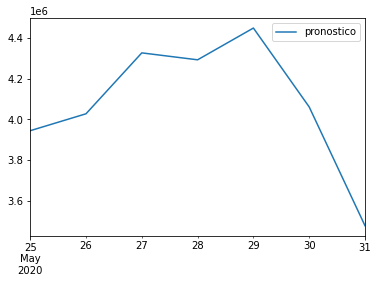

In [49]:
e_date = datetime.datetime.strptime('2020-05-31', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-05-25', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(inverted, index= index_days)
prediccion.columns = ['pronostico']
prediccion.plot()

In [50]:
datosReales = df['2020-5-25':'2020-5-31']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']

compara

,real,prediccion
2020-05-25,4382232,3944844
2020-05-26,4709433,4028108
2020-05-27,4837770,4327766
2020-05-28,4898946,4293658
2020-05-29,4909824,4449944
2020-05-30,4202334,4061748
2020-05-31,3305717,3477415


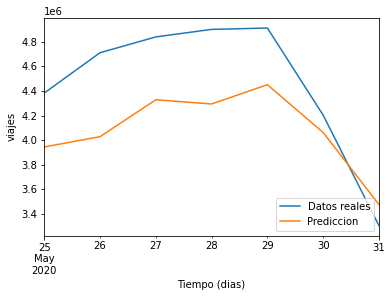

In [51]:
compara['real'].plot()
compara['prediccion'].plot()
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes", fontsize = 10)
plt.legend( ('Datos reales', 'Prediccion'), loc = 'lower right')

In [52]:
# calculamos las metricas de error
testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(prediccion, datosReales)
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del test: 429452.71 MAE
Resultado del test: 220389128875.57 MSE
Resultado del test: 469456.21 RMSE
Resultado del test: 11.50 CVRMSE
Resultado del test: 10.37 MAPE


In [53]:
# calculamos las metricas de error para cada dia por separado
for i in range(7):
    testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(prediccion.values[i], datosReales.values[i])
    day = i + 1
    print('Resultado del test dia %d: %.2f MAE' % (day, testScore_MAE))
    print('Resultado del test dia %d: %.2f MSE' % (day, testScore_MSE))
    print('Resultado del test dia %d: %.2f RMSE' % (day, testScore_RMSE))
    print('Resultado del test dia %d: %.2f CVRMSE' % (day, testScore_CVRMSE))
    print('Resultado del test dia %d: %.2f MAPE \n' % (day, testScore_MAPE))

Resultado del test dia 1: 437388.00 MAE
Resultado del test dia 1: 191308262544.00 MSE
Resultado del test dia 1: 437388.00 RMSE
Resultado del test dia 1: 11.09 CVRMSE
Resultado del test dia 1: 11.09 MAPE 

Resultado del test dia 2: 681325.00 MAE
Resultado del test dia 2: 464203755625.00 MSE
Resultado del test dia 2: 681325.00 RMSE
Resultado del test dia 2: 16.91 CVRMSE
Resultado del test dia 2: 16.91 MAPE 

Resultado del test dia 3: 510004.00 MAE
Resultado del test dia 3: 260104080016.00 MSE
Resultado del test dia 3: 510004.00 RMSE
Resultado del test dia 3: 11.78 CVRMSE
Resultado del test dia 3: 11.78 MAPE 

Resultado del test dia 4: 605288.00 MAE
Resultado del test dia 4: 366373562944.00 MSE
Resultado del test dia 4: 605288.00 RMSE
Resultado del test dia 4: 14.10 CVRMSE
Resultado del test dia 4: 14.10 MAPE 

Resultado del test dia 5: 459880.00 MAE
Resultado del test dia 5: 211489614400.00 MSE
Resultado del test dia 5: 459880.00 RMSE
Resultado del test dia 5: 10.33 CVRMSE
Resultado del 